In [50]:
### Library Import Initialization
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

# Function Import
import sys
sys.path.append('/Users/mburley/MonteCarlo/MonteCarlo')
from MC_Functions import import_stock_data, daily_returns

[*********************100%%**********************]  1 of 1 completed


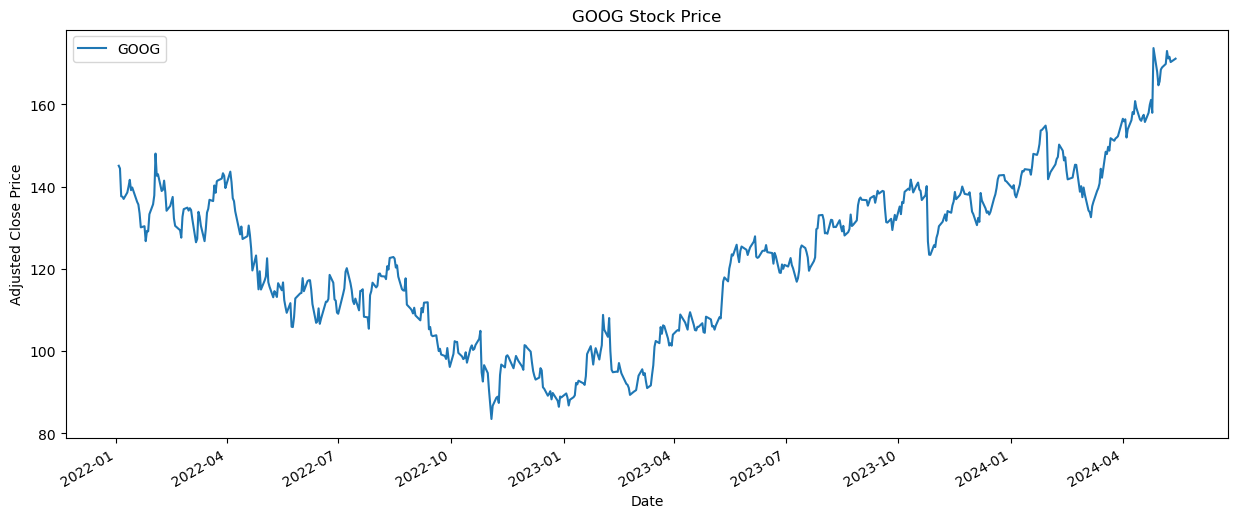

In [51]:
### Function to Import Stock Tickers
# Import Stock Data
tickers = 'GOOG'
start_date = '2022-01-01'
stock_data = import_stock_data(tickers, start_date)

# Plot
stock_data.plot(figsize=(15, 6))
plt.title(f'{tickers} Stock Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.show()

[[171.11500549 171.11500549 171.11500549 ... 171.11500549 171.11500549
  171.11500549]
 [173.54778543 171.32018253 174.04007677 ... 170.0604103  167.83641464
  168.24660471]
 [170.97365598 174.47742841 173.03158142 ... 168.64568342 174.14707137
  167.53865274]
 ...
 [153.36821815 156.66423013 185.65067646 ... 173.18801886 185.55417757
  194.01956825]
 [147.72465538 152.25406175 183.5299259  ... 174.43111442 184.07041465
  193.1526412 ]
 [147.55271873 152.83023715 183.77110921 ... 176.29806716 190.44958617
  188.2698668 ]]


<function matplotlib.pyplot.show(close=None, block=None)>

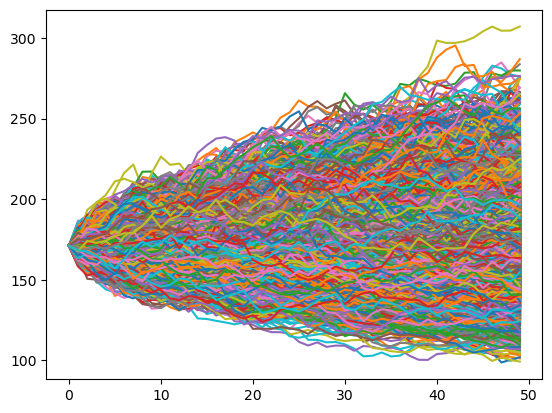

In [52]:
### Function Calls to Compute Daily Log Returns (Brownian Motion) and Generate Paths 
# Compute Daily Returns
days = 50           # Projecting out 50 days
trials = 10000      # Total trials
daily_rets = daily_returns(stock_data, days, trials, return_type = 'log')
#daily_rets

# Generate Price Paths
def price_paths(data, daily_returns):
    # Initialize array with the same shape as daily_returns but filled with zeros
    price_paths = np.zeros_like(daily_returns)
    # Set initial value of price paths to the last value in the stock prices df
    price_paths[0] = data.iloc[-1]

    # Loop over the price paths array and compute the price at each time step (t) based on the previous price (price_paths[t-1]) and the 
    # corresponding daily return (daily_returns[t])
    for t in range(1, days):
        price_paths[t] = price_paths[t-1]*daily_returns[t]

    return price_paths

# Call and Plot each of the 10000 price paths over the 50 day span
paths = price_paths(stock_data, daily_rets)
print(paths)
plt.plot(paths)
plt.show


In [53]:
### Calculate Payoff for each Path
def payoffs(K, price_paths, option_type):
    """
    Calculate the payoffs for each path in a list of price paths based on the 
    option type (call or put). The payoff is computed as: 
        Payoff_t ​= max(0, Strike Price - Asset Price_t​) where t = time step
    """
    num_paths = len(price_paths)
    num_steps = len(price_paths[0])  # Assuming all paths have the same number of steps
    payoffs_matrix = np.zeros((num_paths, num_steps))  # Initialize an array to store payoffs

    for i in range(num_paths):
        for j in range(num_steps):
            if option_type == 'call':
                payoff = max(0, price_paths[i][j] - K)
            elif option_type == 'put':
                payoff = max(0, K - price_paths[i][j])
            else:
                raise ValueError("Invalid option type. Use 'call' or 'put'.")

            payoffs_matrix[i][j] = payoff  # Assign calculated payoff to the matrix

    return payoffs_matrix

# Function Call - For N simulated paths and T time steps, your array of option values would be of size N×T (50x10000)
K = 174
payoff_matrix = payoffs(K, paths, option_type = 'call')
payoff_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.04007677, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.47742841,  0.        , ...,  0.        ,
         0.14707137,  0.        ],
       ...,
       [ 0.        ,  0.        , 11.65067646, ...,  0.        ,
        11.55417757, 20.01956825],
       [ 0.        ,  0.        ,  9.5299259 , ...,  0.43111442,
        10.07041465, 19.1526412 ],
       [ 0.        ,  0.        ,  9.77110921, ...,  2.29806716,
        16.44958617, 14.2698668 ]])

In [55]:
### Regression Analysis
'''
Use polynomial regression on the simulated paths and their corresponding payoffs. The following regression equation aims 
to approximate the continuation value of the option:
    Continuation Value_t ​= β_0 ​+ β_1​⋅Asset Price_t + β_2​⋅Asset Price_t^(2) ​+ ... + β_n​⋅Asset Price_t^(n)
where:
    Continuation Value_t =​ estimated value of continuing the option at time t
    β_0, β_1, ..., β_n = coefficients obtained from the regression analysis
    Asset Price_t =​ price of the underlying asset at time t
    n = is the degree of the polynomial regression
'''
def polynomial_regression(paths, payoffs, degree):
    # Flatten the arrays for regression
    flattened_paths = np.array(paths).flatten()
    flattened_payoffs = np.array(payoffs).flatten()

    # Create polynomial features
    polynomial_features = PolynomialFeatures(degree=degree)
    X_poly = polynomial_features.fit_transform(flattened_paths.reshape(-1, 1))

    # Perform linear regression
    model = LinearRegression()
    model.fit(X_poly, flattened_payoffs)

    # Extract coefficients
    coefficients = model.coef_

    return coefficients